In [1]:
# Comparing using some data vs all data when not much has been collected yet.
# Goal is to choose between many sampled models or one model with many agents.

In [2]:
import multiprocessing 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import copy

import model_based_agent as mba 
import ensemble_mod_env as eme
import utils as ut
import tab_agents as tab

from datetime import datetime 

In [16]:
def plot_qtabs(agt,vmin=None,vmax=None):
    fig,ax = plt.subplots(1,2)
    for i in range(2):
        img = ax[i].imshow(agt.Qtab[:,i].reshape(12,12),vmin=vmin,vmax=vmax)
        fig.colorbar(img,ax=ax[i])

In [18]:
num_learners = 5
collection_eps = 5

gamma=.25
epsilon=.05
alpha=.01
init_df = 'ensemble_testing.pkl'
qtabs = []

if __name__=='__main__':
    
    '''
    Runs parallel learners and joins them afterward
    '''

    worm_agent = tab.Q_Alpha_Agent(gamma=gamma, epsilon=epsilon, alpha=alpha) # Agent doesn't learn
    # Start model environments and learners 
    dh = mba.DataHandler()
    dh.load_df(init_df)
    dh.df = dh.df[:2000]
    
    for loop in range(collection_eps):        
        # Make new learner list based on newest data
        learners = mba.make_learner_list(num_learners, worm_pars={'num_models':1, 'frac':1},
                                gamma=gamma, epsilon=epsilon, alpha=alpha, q_checkpoint=worm_agent.Qtab)        
        
        # Start multiprocessing
        manager = multiprocessing.Manager()
        poison_queue = manager.Queue()
        pool = multiprocessing.Pool()
        
        # Run main functions: train agents and collect more data
        lea_outs = []
        print('learning')
        for lea in learners:
            lea_outs.append(pool.apply_async(lea.learn, [dh],{'learn_limit':1000}))
        # Wait for them to finish
        pool.close()
        pool.join()
        for lea_out in lea_outs:
            if lea_out.successful() is False:
                raise Exception('One learner failed')
        
        # Combining learners from run
        worm_agent.Qtab = mba.combine_learners(lea_outs)
        qtabs.append(worm_agent.Qtab.reshape((12,12,2)))

learning
learning
learning
learning
learning


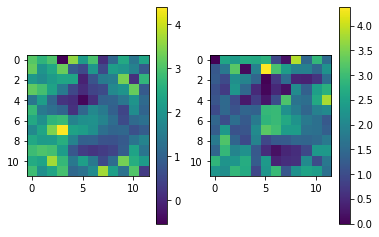

In [19]:
plot_qtabs(worm_agent)

In [13]:
num_learners = 1
collection_eps = 1

gamma=.25
epsilon=.05
alpha=.01
init_df = 'ensemble_testing.pkl'
qtabs = []


worm_agent = tab.Q_Alpha_Agent(gamma=gamma, epsilon=epsilon, alpha=alpha) # Agent doesn't learn
# Start model environments and learners 
dh = mba.DataHandler()
dh.load_df(init_df)
dh.df = dh.df
    
# for loop in range(collection_eps):        
#     # Make new learner list based on newest data
#     learners = mba.make_learner_list(num_learners, worm_pars={'num_models':1, 'frac':1},
#                             gamma=gamma, epsilon=epsilon, alpha=alpha, q_checkpoint=worm_agent.Qtab)        
#     print('learning')
#     for lea in learners:
#         lea.learn(dh,learn_limit=100)

In [13]:
mset = eme.ModelSet(1,frac=1)
mset.make_models(dh,{'lambda':.05,'iters':30})

On model 0


In [14]:
for ob in np.arange(-180,180,30):
    for obh in np.arange(-180,180,30):
        print(f"Ob: {ob} {obh}: {len(dh.df.query('obs_b=='+str(ob)+'& obs_h=='+str(obh)))}")

Ob: -180 -180: 0
Ob: -180 -150: 0
Ob: -180 -120: 0
Ob: -180 -90: 0
Ob: -180 -60: 0
Ob: -180 -30: 0
Ob: -180 0: 0
Ob: -180 30: 0
Ob: -180 60: 0
Ob: -180 90: 0
Ob: -180 120: 0
Ob: -180 150: 0
Ob: -150 -180: 0
Ob: -150 -150: 0
Ob: -150 -120: 3
Ob: -150 -90: 3
Ob: -150 -60: 8
Ob: -150 -30: 43
Ob: -150 0: 25
Ob: -150 30: 15
Ob: -150 60: 37
Ob: -150 90: 0
Ob: -150 120: 0
Ob: -150 150: 0
Ob: -120 -180: 2
Ob: -120 -150: 3
Ob: -120 -120: 0
Ob: -120 -90: 0
Ob: -120 -60: 12
Ob: -120 -30: 11
Ob: -120 0: 3
Ob: -120 30: 4
Ob: -120 60: 3
Ob: -120 90: 5
Ob: -120 120: 1
Ob: -120 150: 0
Ob: -90 -180: 0
Ob: -90 -150: 0
Ob: -90 -120: 0
Ob: -90 -90: 0
Ob: -90 -60: 0
Ob: -90 -30: 0
Ob: -90 0: 0
Ob: -90 30: 0
Ob: -90 60: 0
Ob: -90 90: 2
Ob: -90 120: 0
Ob: -90 150: 0
Ob: -60 -180: 0
Ob: -60 -150: 0
Ob: -60 -120: 0
Ob: -60 -90: 3
Ob: -60 -60: 1
Ob: -60 -30: 23
Ob: -60 0: 32
Ob: -60 30: 28
Ob: -60 60: 32
Ob: -60 90: 1
Ob: -60 120: 1
Ob: -60 150: 0
Ob: -30 -180: 0
Ob: -30 -150: 3
Ob: -30 -120: 5
Ob: -30 -90: 6
O

In [36]:
for ob in np.arange(-180,180,30):
    print(f"Ob: {ob} {obh}: {len(dh.df.query('obs_b=='+str(ob)))}")

Ob: -180 150: 29
Ob: -150 150: 5910
Ob: -120 150: 4693
Ob: -90 150: 41
Ob: -60 150: 6331
Ob: -30 150: 4361
Ob: 0 150: 46
Ob: 30 150: 6933
Ob: 60 150: 4936
Ob: 90 150: 87
Ob: 120 150: 6362
Ob: 150 150: 4178


In [7]:
plt.figure(figsize=(3,3))
plt.imshow(learners[0].modset.models[0]['reward_on'][:,:,0])
plt.colorbar();

IndexError: list index out of range

<Figure size 216x216 with 0 Axes>

In [12]:
learners[0].modset.models

[]

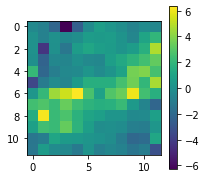

In [27]:
plt.figure(figsize=(3,3))
plt.imshow(mset.models[0]['reward_on'][:,:,0])
plt.colorbar();

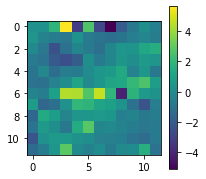

In [28]:
plt.figure(figsize=(3,3))
plt.imshow(mset.models[0]['reward_off'][:,:,0])
plt.colorbar();

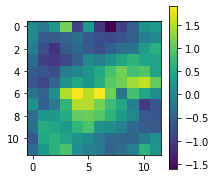

In [30]:
plt.figure(figsize=(3,3))
plt.imshow(mset.models[0]['reward_off'][:,:,0])
plt.colorbar();

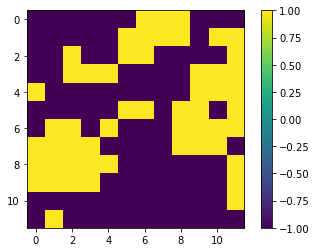

In [15]:
plt.imshow(np.sign(-1+mset.models[0]['reward_on'][:,:,0]-mset.models[0]['reward_off'][:,:,0]))
plt.colorbar();

In [35]:
def smoothen_dev(matrix,counts,ang,smooth_par=.05,iters=30,wraparound=True,diagonals=True): 
    # matrix is in form [12,12]
    # counts is [12,12].
    # ang is bool, True if angle matrix
    # Will start with a simple weighted average between nearest neighbors and diagonals.
    #
    # Derivation for procedure in CL's nb page 81
    
    if np.array_equal(matrix,counts):
        count_version = True
    else:
        count_version = False
        
    if not np.all(counts):
        counts+=1
    # So the shapes start out right before looping 
    matrix = make_wraparound(matrix, ang, wraparound=True)
    counts = make_wraparound(counts, False, wraparound=True)
    if ang:
        buffer=180
    else:
        buffer=None
    
    for it in range(iters):
        matrix = make_wraparound(matrix[1:-1,1:-1], ang, wraparound=True)
        tempmat = np.copy(matrix) # Now tempmat and matrix are the same extended size
        rows,cols = np.array(matrix.shape)-2 

        # Loops through each matrix element and weights changes by counts
        for i in np.arange(rows)+1:
            for j in np.arange(cols)+1:
                neighs = wrap_correct(get_neighbors(matrix,(i,j)), ref=matrix[i,j], buffer=buffer)
                neigh_counts = get_neighbors(counts,(i,j))
                prod_nn = np.sum(np.multiply(neigh_counts, neighs))
                c_nn = np.sum(neigh_counts)
                
                if diagonals:
                    # Diagonal entries (scaled by 1/sqrt(2))
                    neighs_d = wrap_correct(get_diags(matrix,(i,j)), ref=matrix[i,j], buffer=buffer)
                    neigh_counts_d = get_diags(counts,(i,j))
                    prod_d = np.sum(np.multiply(neigh_counts_d, neighs_d))
                    c_d = np.sum(neigh_counts_d)
                    
                    mu = (prod_nn/c_nn + prod_d/(np.sqrt(2)*c_d)) / (1+np.sqrt(2))
                    alpha = 1/(1+(4*counts[i,j]*(1+np.sqrt(2)))/(c_nn+c_d))
                    
                else:
                    mu = prod_nn/c_nn
                    alpha = 1/(1+(4*counts[i,j]/c_nn))
                    
                tempmat[i,j] = tempmat[i,j] + smooth_par*alpha*(mu - tempmat[i,j])
            
                
        # After tempmat is updated, set reference matrix to be the same
        # This way updates within one iteration don't get included in the same iteration
        matrix = np.copy(tempmat)
        if not count_version:
            counts = smoothen_dev(counts,counts,False,smooth_par=smooth_par,iters=1)
    
    return wrap_correct(matrix[1:-1,1:-1], buffer=buffer)

In [108]:
def make_dist_dict(df, sm_pars=None,
    prev_act_window=3,
    cut_reversals=True):
    # Makes a dictionary of distributions using trajectory statistics.
    # sm_pars is a dict of form {'lambda': .05, 'iters': 30}
    #     If None, then no smoothing.
    # cut_reversals is a boolean

    traj_on = df.query('prev_actions=='+str(prev_act_window))
    traj_off = df.query('prev_actions==0')

    r_on, b_on, h_on, count_on = make_stat_mats(traj_on, cut_reversals=cut_reversals)
    r_off, b_off, h_off, count_off = make_stat_mats(traj_off, cut_reversals=cut_reversals)

    all_mats = [r_on,b_on,h_on,r_off,b_off,h_off]
    counts = [count_on,count_off]

    for i in range(len(all_mats)):
        for j in range(2):
            if j==1 or i==0 or i==3:
                ang_par = False
            else:
                ang_par = True
            all_mats[i][:,:,j] = lin_interp_mat(all_mats[i][:,:,j], ang_par)
            
            if sm_pars is not None:
                all_mats[i][:,:,j] = smoothen(all_mats[i][:,:,j], 
                                                counts[i//3], ang_par, 
                                                smooth_par=sm_pars['lambda'], iters=sm_pars['iters'])

    dist_dict = {
        'body_on': b_on,
        'body_off': b_off,
        'head_on': h_on,
        'head_off': h_off,
        'reward_on': r_on,
        'reward_off': r_off,
    }    
    return dist_dict, counts

def add_to_traj(trajectory,info):
    # appends each key in info to the corresponding key in trajectory.
    # If trajectory is empty, returns trajectory as copy of info but with each element as list
    # so it can be appended to in the future.

    if trajectory:
        for k in info.keys():
            trajectory[k].append(info[k])
    else:
        for k in info.keys():
            trajectory[k] = [info[k]]

def make_stat_mats(df, cut_reversals=True):
    # This version should have an option to check HT switches so I can test.
    # Inner func does most of the work querying for each obs.
    # cut_reversals is True if body angle switches happen. Note that it does cut both incorrect
    #   switches and correct ones.
    # Returns everything at once: 
    #   r_mat[12,12,2], b_mat[12,12,2], h_mat[12,12,2], counts[12,12].

    def get_stats_angs(df, obs, cut_reversals=True):
        # Gets mean and var of df values that match obs, centered on obs
        # Remove points where HT orientation switched
        # Returns r_stats, b_stats, h_stats, count. The first three are tuples [mu,var].

        if cut_reversals:
            backwards = obs[0]-180
            if backwards < -180:
                backwards += 360
        else:
            backwards = 1e5

        df_d = dict(zip(df.columns,range(len(df.columns))))
        series = df.query('obs_b=='+str(obs[0])+'& obs_h=='+str(obs[1])+
            '& next_obs_b!='+str(backwards)).copy()
        series.iloc[:,df_d['next_obs_b']] = wrap_correct(series['next_obs_b'].to_numpy(),ref=series['obs_b'].to_numpy(),buffer=180)
        series.iloc[:,df_d['next_obs_h']] = wrap_correct(series['next_obs_h'].to_numpy(),ref=series['obs_h'].to_numpy(),buffer=180)

        # Handles case for one sample (initialize)
        r_sts,b_sts,h_sts,count = [np.nan,np.nan],[np.nan,np.nan],[np.nan,np.nan],0
        if series.size > 0:    
            r_sts[0],b_sts[0],h_sts[0] = wrap_correct(series['reward'].mean(),buffer=None), \
                                            wrap_correct(series['next_obs_b'].mean(),buffer=180), \
                                            wrap_correct(series['next_obs_h'].mean(),buffer=180)
            if series.size > 1:
                r_sts[1],b_sts[1],h_sts[1] = series['reward'].var(), \
                                                series['next_obs_b'].var(), \
                                                series['next_obs_h'].var()
        return r_sts,b_sts,h_sts,series.size


    r_mat = np.zeros((12,12,2)) + np.nan 
    b_mat = np.zeros((12,12,2)) + np.nan 
    h_mat = np.zeros((12,12,2)) + np.nan 
    counts = np.zeros((12,12))

    for i,theta_b in enumerate(np.arange(-180,180,30)):
        for j,theta_h in enumerate(np.arange(-180,180,30)):
            r_sts,b_sts,h_sts,counts[i,j] = get_stats_angs(df,[theta_b,theta_h])
            r_mat[i,j,:] = r_sts
            b_mat[i,j,:] = b_sts
            h_mat[i,j,:] = h_sts

    return r_mat, b_mat, h_mat, counts

'''
Matrix regularizers: interpolation and smoothing
'''
def lin_interp_mat(mat,ang,wraparound=True):
    # Fills in NaNs in matrix by linear interpolation. 
    # ang is a boolean (True if data are for angles)
    # Only considers nearest neighbors (no diagonals).
    # Fills in NaNs from most neighbors to least neighbors.
    # wraparound extends matrix in all four directions. 
    if ang:
        buffer=180
    else:
        buffer=1e6

    mat = make_wraparound(mat,ang,wraparound=wraparound)

    # Find nans in relevant matrix section
    nan_inds = np.argwhere(np.isnan(mat[1:-1,1:-1])) + 1
        # add 1 because need index for extended matrix
    
    neighbor_lim = 3
    while nan_inds.size>0: 
        candidates = 0
        for ind in nan_inds:
            neighbors = get_neighbors(mat,ind)
            if sum(~np.isnan(neighbors)) >= neighbor_lim:
                mat[ind[0],ind[1]] = np.mean(wrap_correct(neighbors[~np.isnan(neighbors)], ref=min(neighbors), buffer=buffer))
                candidates+=1
        if candidates==0:
            neighbor_lim-=1
        nan_inds = np.argwhere(np.isnan(mat[1:-1,1:-1])) + 1

    return wrap_correct(mat[1:-1,1:-1],buffer=buffer)

def smoothen(matrix,counts,ang,smooth_par=.05,iters=30,wraparound=True,diagonals=True): 
    # matrix is in form [12,12]
    # counts is [12,12].
    # ang is bool, True if angle matrix
    # Will start with a simple weighted average between nearest neighbors and diagonals.
    #
    # Derivation for procedure in CL's nb page 81
    
    if np.array_equal(matrix,counts):
        count_version = True
    else:
        count_version = False
        
    if not np.all(counts):
        counts+=1
    # So the shapes start out right before looping 
    matrix = make_wraparound(matrix, ang, wraparound=True)
    counts = make_wraparound(counts, False, wraparound=True)
    if ang:
        buffer=180
    else:
        buffer=None
    
    for it in range(iters):
        matrix = make_wraparound(matrix[1:-1,1:-1], ang, wraparound=True)
        tempmat = np.copy(matrix) # Now tempmat and matrix are the same extended size
        rows,cols = np.array(matrix.shape)-2 

        # Loops through each matrix element and weights changes by counts
        for i in np.arange(rows)+1:
            for j in np.arange(cols)+1:
                neighs = wrap_correct(get_neighbors(matrix,(i,j)), ref=matrix[i,j], buffer=buffer)
                neigh_counts = get_neighbors(counts,(i,j))
                prod_nn = np.sum(np.multiply(neigh_counts, neighs))
                c_nn = np.sum(neigh_counts)
                
                if diagonals:
                    # Diagonal entries (scaled by 1/sqrt(2))
                    neighs_d = wrap_correct(get_diags(matrix,(i,j)), ref=matrix[i,j], buffer=buffer)
                    neigh_counts_d = get_diags(counts,(i,j))
                    prod_d = np.sum(np.multiply(neigh_counts_d, neighs_d))
                    c_d = np.sum(neigh_counts_d)
                    
                    mu = (prod_nn/c_nn + prod_d/(np.sqrt(2)*c_d)) / (1+np.sqrt(2))
                    alpha = 1/(1+(4*counts[i,j]*(1+np.sqrt(2)))/(c_nn+c_d))
                    
                else:
                    mu = prod_nn/c_nn
                    alpha = 1/(1+(4*counts[i,j]/c_nn))
                    
                tempmat[i,j] = tempmat[i,j] + smooth_par*alpha*(mu - tempmat[i,j])
            
                
        # After tempmat is updated, set reference matrix to be the same
        # This way updates within one iteration don't get included in the same iteration
        matrix = np.copy(tempmat)
        if not count_version:
            counts = smoothen(counts,counts,False,smooth_par=smooth_par,iters=1)
    
    return wrap_correct(matrix[1:-1,1:-1], buffer=buffer)

'''
Small funcs and utils
'''
def wrap_correct(arr_orig,ref=0,buffer=180):
    # Takes angles and translates them to +/-buffer around ref.
    # For things like std, use large buffer so it doesn't change
    # If both arrays, send each element through this function.
    if buffer is None:
        return arr_orig
    
    if hasattr(arr_orig,"__len__"):
        arr = arr_orig.copy()
        if hasattr(ref,"__len__"):
            for i in range(len(arr)):
                arr[i] = wrap_correct(arr[i],ref=ref[i],buffer=buffer)
        # If only arr is an array
        else:
            arr[arr<ref-buffer]+=buffer*2
            arr[arr>=ref+buffer]-=buffer*2
            if len(arr[arr<ref-buffer])>0 or len(arr[arr>=ref+buffer])>0:
                arr = wrap_correct(arr,ref=ref,buffer=buffer)
    else:
        arr = arr_orig
        if arr<ref-buffer:
            arr+=buffer*2
            if arr<ref-buffer:
                arr = wrap_correct(arr,ref=ref,buffer=buffer)
        elif arr>=ref+buffer:
            arr-=buffer*2
            if arr>=ref+buffer:
                arr = wrap_correct(arr,ref=ref,buffer=buffer)
    return arr
        
def make_wraparound(mat,ang,wraparound=True):
    # Expands matrix for wraparound interpolation
    # If matrix is angle values, set ang=True.
    mat_new = np.zeros((np.array(mat.shape)+2)) + np.nan
    mat_new[1:-1,1:-1] = mat
    if ang:
        buffer=180
    else:
        buffer=None

    if wraparound:
        # diagonals
        mat_new[0,0] = wrap_correct(mat[-1,-1], ref=mat[0,0], buffer=buffer)
        mat_new[0,-1] = wrap_correct(mat[-1,0], ref=mat[0,-1], buffer=buffer)
        mat_new[-1,0] = wrap_correct(mat[0,-1], ref=mat[-1,0], buffer=buffer)
        mat_new[-1,-1] = wrap_correct(mat[0,0], ref=mat[-1,-1], buffer=buffer)
        # adjacents
        mat_new[0,1:-1] = wrap_correct(mat[-1,:], ref=mat[0,:], buffer=buffer)
        mat_new[-1,1:-1] = wrap_correct(mat[0,:], ref=mat[-1,:], buffer=buffer)
        mat_new[1:-1,0] = wrap_correct(mat[:,-1], ref=mat[:,0], buffer=buffer)
        mat_new[1:-1,-1] = wrap_correct(mat[:,0], ref=mat[:,-1], buffer=buffer)
    return mat_new

def get_neighbors(mat,i):
    # Makes array of four neighbors around mat[index]
    # index is a pair
    return np.array([mat[i[0],i[1]-1], mat[i[0],i[1]+1], mat[i[0]-1,i[1]], mat[i[0]+1,i[1]]])

def get_diags(mat,i):
    return np.array([mat[i[0]-1,i[1]-1], mat[i[0]-1,i[1]+1], mat[i[0]+1,i[1]-1], mat[i[0]+1,i[1]+1]])

def myround(x, base=30):
    return base * round(x/base)

In [14]:
dh.df

,t,obs_b,obs_h,prev_actions,next_obs_b,next_obs_h,reward,loc
0,0.953,30,60,3,-150,-120,-3.616162,"[848.7272727272727, 1067.8181818181818]"
1,1.140,-150,-120,3,30,-30,-0.737374,"[848.3, 1068.0]"
2,1.312,30,-30,3,150,-60,-1.857143,"[848.25, 1068.0]"
3,1.500,150,-60,2,150,-60,1.714286,"[847.8333333333334, 1068.1666666666667]"
4,1.672,150,-60,1,150,150,-0.033333,"[848.0, 1068.125]"
...,...,...,...,...,...,...,...,...
43902,218.109,30,60,3,-150,60,-7.254115,"[1480.469387755102, 1080.8163265306123]"
43903,218.312,-150,60,3,-150,0,-6.373234,"[1480.7021276595744, 1080.6170212765958]"
43904,218.484,-150,0,3,-150,0,-7.764628,"[1479.842105263158, 1081.4736842105262]"
43905,218.672,-150,0,3,-120,-60,-6.646453,"[1478.9166666666667, 1082.4166666666667]"


In [115]:
dd,counts0 = make_dist_dict(dh.df,sm_pars={'lambda':.5,'iters':20})

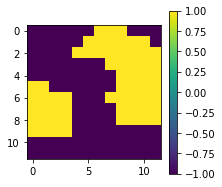

In [116]:
plt.figure(figsize=(3,3))
plt.imshow(np.sign(dd['reward_on'][:,:,0]-dd['reward_off'][:,:,0]-.15))
plt.colorbar();

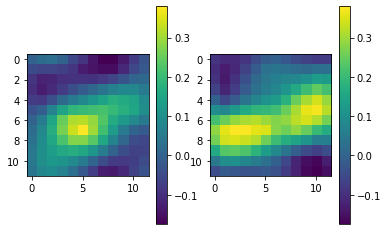

In [117]:
fig,ax = plt.subplots(1,2)
img=ax[0].imshow(dd['reward_off'][:,:,0])
fig.colorbar(img,ax=ax[0])
ax[1].imshow(dd['reward_on'][:,:,0])
fig.colorbar(img,ax=ax[1])

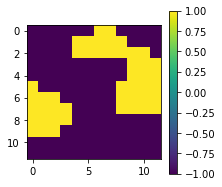

In [78]:
plt.figure(figsize=(3,3))
plt.imshow(np.sign(dd['reward_on'][:,:,0]-dd['reward_off'][:,:,0]-.15))
plt.colorbar();

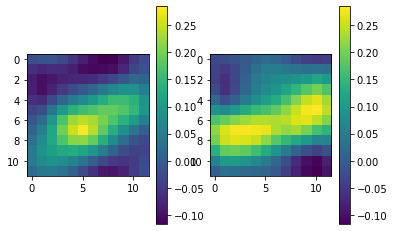

In [72]:
fig,ax = plt.subplots(1,2)
img=ax[0].imshow(dd['reward_off'][:,:,0])
fig.colorbar(img,ax=ax[0])
ax[1].imshow(dd['reward_on'][:,:,0])
fig.colorbar(img,ax=ax[1])

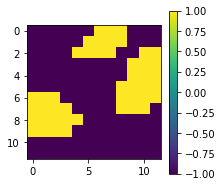

In [84]:
plt.figure(figsize=(3,3))
plt.imshow(np.sign(dd['reward_on'][:,:,0]-dd['reward_off'][:,:,0]-.4))
plt.colorbar();

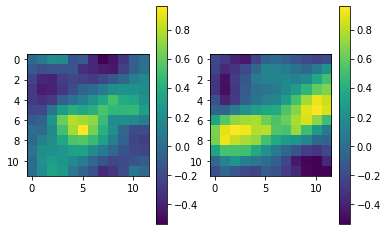

In [81]:
fig,ax = plt.subplots(1,2)
img=ax[0].imshow(dd['reward_off'][:,:,0])
fig.colorbar(img,ax=ax[0])
ax[1].imshow(dd['reward_on'][:,:,0])
fig.colorbar(img,ax=ax[1])

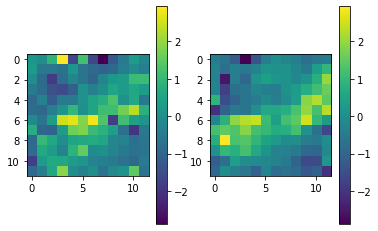

In [67]:
fig,ax = plt.subplots(1,2)
img=ax[0].imshow(dd['reward_off'][:,:,0])
fig.colorbar(img,ax=ax[0])
ax[1].imshow(dd['reward_on'][:,:,0])
fig.colorbar(img,ax=ax[1])

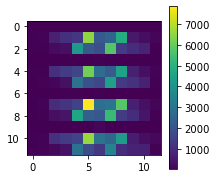

In [68]:
plt.figure(figsize=(3,3))
plt.imshow(counts0[0])
plt.colorbar();

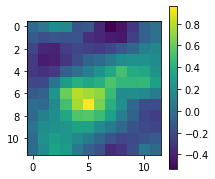

In [63]:
plt.figure(figsize=(3,3))
plt.imshow(dd['reward_off'][:,:,0])
plt.colorbar();

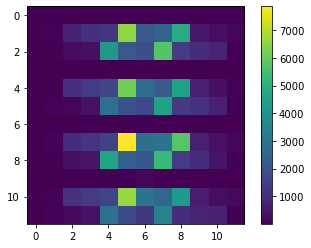

In [38]:
plt.imshow(counts0[0])
plt.colorbar();